## Ex 1: Network Projection on an Undirected Bipartite Graph

This section illustrates the use of the network projection algorithm on the bipartite graph G.

To learn more, visit the [projection documentation](https://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=default&docsetId=casmlnetwork&docsetTarget=casmlnetwork_network_syntax22.htm&locale=en).

In [1]:
import pandas as pd
import swat
import sys
sys.path.append(r"../../../common/python")
import visualization as vz
import cas_connection as cas

In [2]:
swat.options.cas.print_messages=False
s = cas.reconnect()
s.loadActionSet('network')

[actionset]

 'network'

+ Elapsed: 0.00369s, user: 0.002s, sys: 0.000999s, mem: 0.253mb

### Define the Input Graph
The bipartite graph G can be represented by the following links data:

In [3]:
from_col = list('AAABBBBCCCCDDEEE')
to_col   = list('1231245234535456')
df_links = pd.DataFrame({'from': from_col, 'to':to_col})

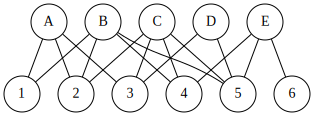

In [4]:
vz.graph2dot(
    linksDf    = df_links, 
    directed   = 0,
    graphAttrs = {"layout":"dot", "rankdir":"TB"},
    stdout     = False
) 

To perform a network projection using the projection action, it is necessary to indicate which nodes belong to each partition. In this case, nodes A through E belong to one partition of the bipartite graph, and nodes 1 through 6 belong to the second partition. We can easily define the nodes table by marking partitionFlag=1 for nodes in the 'from' column, and partitionFlag=0 for nodes in the 'to' column.

In [5]:
nodes = [[node, 1] for node in df_links['from'].unique()] + [[node, 0] for node in df_links['to'].unique()]
df_nodes = pd.DataFrame(nodes, columns = ['node', 'partitionFlag'])
df_nodes.head(11)

,node,partitionFlag
0,A,1
1,B,1
2,C,1
3,D,1
4,E,1
5,1,0
6,2,0
7,3,0
8,4,0
9,5,0


Next, upload the tables into CAS

In [6]:
s.upload(df_links, casout = {'name':'links', 'replace':True})
s.upload(df_nodes, casout = {'name':'nodes', 'replace':True});

### Run the Projection Algorithm

In [7]:
s.network.projection(
    indexOffset        = 1,
    links              = {"name": "links"},
    nodes              = {"name": "nodes"},
    outProjectionLinks = {"name": "links_out", "replace":True},
    partition          = "partitionFlag",
    commonNeighbors    = True
    );

In [8]:
s.CASTable("links_out").head(10)

,from,to,commonNeighbors
0,A,B,2.0
1,A,C,2.0
2,A,D,1.0
3,B,C,3.0
4,B,D,1.0
5,B,E,2.0
6,C,D,2.0
7,C,E,2.0
8,D,E,1.0


### Visualize the Result
For pretty visualization, it is a good idea to convert the commonNeighbors column to integer values before using it as the link weight label.

In [9]:
def show_projected_output(links_table, directed=0):
    df_links_out = s.CASTable(links_table).to_frame()
    df_links_out["commonNeighbors"] = df_links_out["commonNeighbors"].astype(int)
    return vz.graph2dot(
        linksDf    = df_links_out, 
        directed   = directed,
        graphAttrs = {"layout":"circo"},
        linkAttrs  = {"label":"commonNeighbors"},
        stdout     = False
    ) 

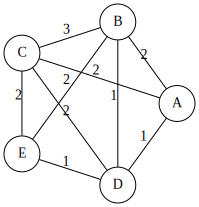

In [10]:
show_projected_output('links_out')

## Ex 2: Network Projection of a Directed Bipartite Graph

This section provides additional examples to illustrate the three ways to define projection on a graph with directed links.

In [11]:
node_col = ['0','1','A','B','C','D']
part_col = [ 0 , 0 , 1 , 1 , 1 , 1 ]
df_nodes = pd.DataFrame({'node': node_col, 'partitionFlag':part_col})

In [12]:
from_col = list('11AAD')
to_col   = list('BC010')
df_links = pd.DataFrame({'from': from_col, 'to':to_col})

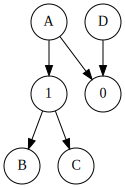

In [13]:
vz.graph2dot(
    linksDf    = df_links, 
    directed   = 1,
    graphAttrs = {"layout":"dot", "rankdir":"TB"},
    stdout     = False
) 

Next, upload the tables into CAS

In [14]:
s.upload(df_links, casout = {'name':'links', 'replace':True})
s.upload(df_nodes, casout = {'name':'nodes', 'replace':True});

### Run the Projection Algorithm

The following statements find the projection of the network onto nodes A through D via their out-neighbors:

In [15]:
s.network.projection(
    indexOffset        = 1,
    direction          = "directed",
    directedMethod     = "converging",
    links              = {"name": "links"},
    nodes              = {"name": "nodes"},
    outProjectionLinks = {"name": "links_out1", "replace":True},
    partition          = "partitionFlag",
    commonNeighbors    = True
    );

In [16]:
s.CASTable("links_out1").head()

,from,to,commonNeighbors
0,A,D,1.0


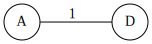

In [17]:
show_projected_output('links_out1')

The following statements find the projection of the network onto nodes A through D via their in-neighbors:

In [18]:
s.network.projection(
    indexOffset        = 1,
    direction          = "directed",
    directedMethod     = "diverging",
    links              = {"name": "links"},
    nodes              = {"name": "nodes"},
    outProjectionLinks = {"name": "links_out2", "replace":True},
    partition          = "partitionFlag",
    commonNeighbors    = True
    );

In [19]:
s.CASTable("links_out2").head()

,from,to,commonNeighbors
0,B,C,1.0


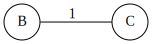

In [20]:
show_projected_output('links_out2')

The following statements find the projection of the network onto nodes A through D via directed paths of length 2:

In [21]:
s.network.projection(
    indexOffset        = 1,
    direction          = "directed",
    directedMethod     = "transitive",
    links              = {"name": "links"},
    nodes              = {"name": "nodes"},
    outProjectionLinks = {"name": "links_out3", "replace":True},
    partition          = "partitionFlag",
    commonNeighbors    = True
    );

In [22]:
s.CASTable("links_out3").head()

,from,to,commonNeighbors
0,A,B,1.0
1,A,C,1.0


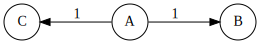

In [23]:
show_projected_output('links_out3', directed=1)